In [1]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5,],std=[0.5,])])

data_train=datasets.FashionMNIST(root='data/',transform=transform,train=True,download=True)
data_test=datasets.FashionMNIST(root='data/',transform=transform,train=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\train-images-idx3-ubyte.gz to data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data/FashionMNIST\raw



D:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [20]:
# shuffle = True to choose picture randomly
data_loader_train=torch.utils.data.DataLoader(dataset=data_train,batch_size=128,shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset =data_test,batch_size = 128,shuffle = True)
 

torch.Size([128, 1, 28, 28])
torch.Size([3, 482, 242])
after transpose shape: (482, 242, 3)
[tensor(9), tensor(4), tensor(9), tensor(4), tensor(4), tensor(6), tensor(6), tensor(7), tensor(8), tensor(4), tensor(8), tensor(0), tensor(6), tensor(3), tensor(3), tensor(4)]


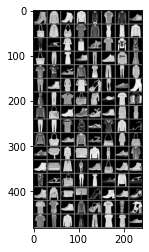

In [22]:
images,labels=next(iter(data_loader_train))
# Splicing the 64 pictures into one picture to see what the pictures look like
print(images.shape)
img=torchvision.utils.make_grid(images)
print(img.shape)
# transpose the img because imshow need a img construction of (height,weight,channel) 
# but img has a construction of (channel,height,weight)

img=img.numpy().transpose(1,2,0)

print("after transpose shape:",img.shape)
# Gray stretch
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i].data for i in range(16)])

plt.imshow(img)
plt.show()


In [23]:
# origin shape of image is (1,28,28)
class CNN_Net(torch.nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            # Convolution change to (64,28,28)
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            # Maxpooling change to (64,14,14)
            torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.conv2=torch.nn.Sequential(
            # Convolution change to (128,14,14)
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            # Maxpooling change to (128,7,7)
            torch.nn.MaxPool2d(stride=2, kernel_size=2))
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(128 * 7 * 7, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024, 10))

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        # change the size to one column to match the linear layer
        x = x2.view(-1, 128 * 7 * 7)
        x = self.dense(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [24]:
cnn = CNN_Net()
# use GPU to accelerate
if torch.cuda.is_available():
    cnn = cnn.cuda()

# CrossEntropy = softmax + log + NLL loss

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)

def train():
    for data in data_loader_train:
        x_train, y_train = data
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_hat = cnn(x_train)
        loss = loss_func(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch %d, loss %.4f' % (epoch + 1, loss))
    return loss  

In [25]:
def test():
    correct = 0
    for data in data_loader_test:
        x_test, y_test = data
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = cnn(x_test)
        _, predict = torch.max(outputs.data, dim=1)
        correct += torch.sum(predict == y_test.data)
    correct = correct.detach().cpu().numpy()
    print("correct rate = ",100 * correct/len(data_test))
    return 100 * correct/len(data_test) *0.01

epoch 1, loss 0.3797
correct rate =  86.22
epoch 2, loss 0.2961
correct rate =  87.34
epoch 3, loss 0.2565
correct rate =  88.86
epoch 4, loss 0.2112
correct rate =  89.96
epoch 5, loss 0.2444
correct rate =  90.53
epoch 6, loss 0.1972
correct rate =  90.91
epoch 7, loss 0.1943
correct rate =  91.11
epoch 8, loss 0.1386
correct rate =  91.49
epoch 9, loss 0.2352
correct rate =  91.4
epoch 10, loss 0.0759
correct rate =  91.18


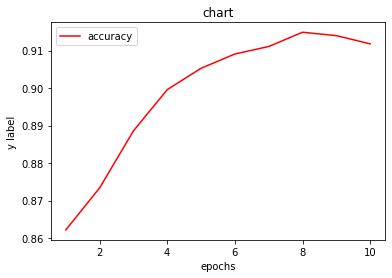

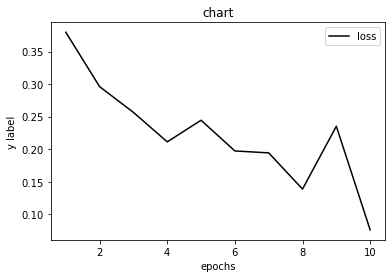

In [26]:
lss = []
acc = []
epochs = []
for epoch in range(10):
    epochs.append(epoch+1)
    ls = train();
    ac = test();
    l_tmp = ls.detach().cpu().numpy()
    lss.append(l_tmp)
    acc.append(ac);
    
plt.plot(epochs,acc,color='r',label='accuracy')  
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()   
plt.show()

plt.plot(epochs,lss,color=(0,0,0),label='loss')
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()            
plt.show()